# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [1]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import networkx as nx
import seaborn as sns

from src.model.training.rollout_data import RolloutBuffer as Buffer
from src.task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from src.utils.config_utils import parse_task_config, parse_model_config, load_config
from src.utils.pytorch_utils import DEVICE
from src.model.agents.lookahead_value_iteration import LookaheadViAgent
from src.model.state_inference.vae import StateVae

from src.utils.pytorch_utils import (
    convert_float_to_8bit
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.6.0.dev20241126
device = mps


In [3]:
CONFIG_PATH = "../configs"
TASK_CONFIG_FILE = "env_config.yml"
VAE_CONFIG_FILE = "vae_config.yml"
AGENT_CONFIG_FILE = "agent_config.yml"

TASK_NAME = "thread_the_needle"
MODEL_NAME = "cnn_vae"

# Create log dir
LOG_DIR = "tmp/"
os.makedirs(LOG_DIR, exist_ok=True)

TASK_CLASS = ThreadTheNeedleEnv
AgentClass = LookaheadViAgent

## Load Configs
task_config_file = os.path.join(CONFIG_PATH, TASK_CONFIG_FILE)
vae_config_file = os.path.join(CONFIG_PATH, VAE_CONFIG_FILE)
agent_config_file = os.path.join(CONFIG_PATH, AGENT_CONFIG_FILE)

env_kwargs = parse_task_config(TASK_NAME, task_config_file)
vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)

# create the task and get the optimal policy
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))
pi, _ = task.get_optimal_policy()

SAVE_FILE_NAME = f"../simulations/thread_the_needle_viagent_offline.csv"

In [4]:
# create the task and get the optimal policy
task = TASK_CLASS.create_env(**env_kwargs)
task = CnnWrapper(task)

# create the monitor
# task = Monitor(task, LOG_DIR)

pi, _ = task.get_optimal_policy()
# training_kwargs["optimal_policy"] = pi

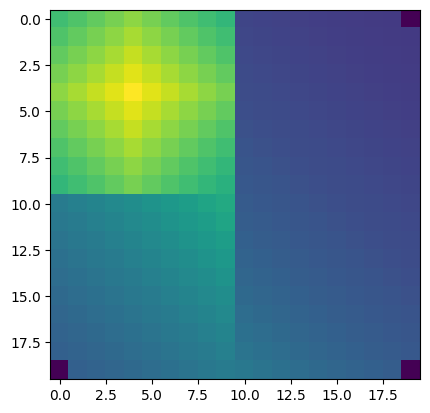

In [85]:
q, v = task.get_optimal_value_function(.95)
plt.imshow(v.reshape(20, 20))

In [84]:
v[83]

9.5

In [78]:
r[:,84]

array([10., 10., 10., 10.])

In [77]:
t = task.transition_model.get_state_action_transitions(task.end_state)
print(t.shape)
r = task.reward_model.construct_rew_func(t)
r[:, task.end_state]

(4, 401, 401)
Setting state 84 to reward 10
[10. 10. 10. 10.]
Setting state 399 to reward -1
[-1. -1. -1. -1.]
Setting state 19 to reward -1
[-1. -1. -1. -1.]
Setting state 380 to reward -1
[-1. -1. -1. -1.]


array([[10., -1., -1., -1.],
       [10., -1., -1., -1.],
       [10., -1., -1., -1.],
       [10., -1., -1., -1.]])

In [52]:
np.argmax(t[:, :, 84], axis=1)

array([104,  64,  85,  83])

In [53]:
r[:, [104, 64, 85, 83]]

array([[10.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.],
       [ 0.,  0., 10.,  0.],
       [ 0.,  0.,  0., 10.]])

In [46]:
{s: task.reward_model.get_reward(s) for s in task.end_state}

{84: 10, 399: -1, 19: -1, 380: -1}

(4, 401, 401) [84, 399, 19, 380]


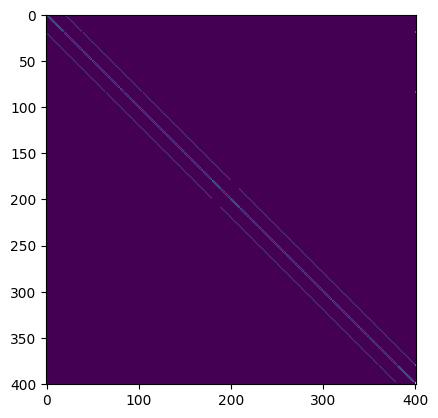

In [20]:
t = task.transition_model.get_state_action_transitions(task.end_state)
print(t.shape, task.end_state)
plt.imshow(t.sum(0))

In [21]:
t[:, task.end_state]

array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]])

In [55]:
### Model + Training Parameters



vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)


def make_model():
    vae = StateVae.make_from_configs(vae_config, env_kwargs)
    agent = LookaheadViAgent(task, vae, **agent_config["state_inference_model"])
    return agent


agent = make_model()
total_params = sum(p.numel() for p in agent.state_inference_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1837074


In [49]:
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices = 1,
)

{'batch_size': 64,
 'n_epochs': 10,
 'grad_clip': 1.0,
 'n_steps': 2048,
 'persistant_optim': True,
 'optim_kwargs': {'lr': 0.0003}}

In [7]:
agent.optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)

In [8]:
agent = make_model()
# agent.learn(total_timesteps=2048, progress_bar=True) # previous model
agent.learn(total_timesteps=20000, progress_bar=True, capacity=8196*2)

Output()

/Users/nicholasfranklin/Projects/StateInference/src/model/state_inference/vae.py:272: UserWarning: Using a target 
size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  reward_loss = F.mse_loss(r_hat, reward.float().to(DEVICE))

In [9]:
pmf = agent.get_policy_prob(agent.get_env(), n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True)
pmf = pmf.squeeze()

Text(0.5, 0.98, 'Value Iteration Agent Learned Policy')

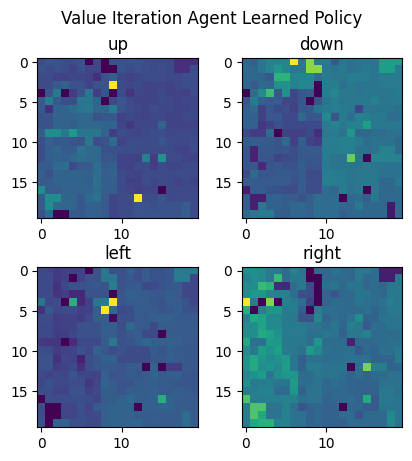

In [10]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

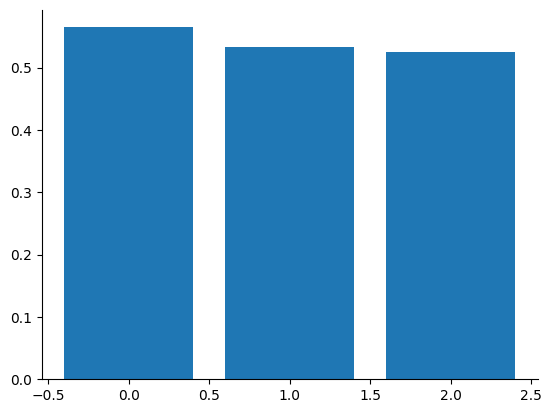

In [11]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

In [12]:
np.argwhere(agent.rollout_buffer.get_dataset()['rewards'] > 0.0)

array([[  383],
       [  852],
       [ 1180],
       [ 1449],
       [ 2285],
       [ 3484],
       [ 4022],
       [ 6473],
       [ 9404],
       [ 9440],
       [ 9690],
       [ 9829],
       [11012],
       [11299],
       [11797],
       [12752],
       [14026],
       [14370],
       [15181],
       [15486],
       [15838]])

In [13]:
mdp = agent.estimate_world_model(agent.rollout_buffer)


In [14]:
Laplacian = mdp.get_graph_laplacian()
Laplacian

tensor([[ 0.8889, -0.1260, -0.1179,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1260,  0.8571, -0.1336,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1179, -0.1336,  0.8750,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])

In [15]:
Laplacian.shape



torch.Size([442, 442])

In [16]:
agent.model_based_agent.transitions.transition_counts.shape


torch.Size([443, 4, 443])

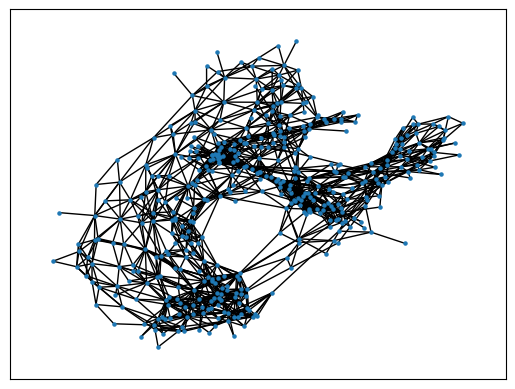

In [17]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian.numpy())
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)

In [18]:
mdp.get_q_values(0)

tensor([2.7845, 2.6999, 2.9390, 2.5739])

In [19]:
# agent.reset_state_indexer()
# mdp = agent.estimate_world_model(rollouts)

v = mdp.estimate_value_function()
v.shape

v_min, v_max = v.min(), v.max()
v_normed = (v - v_min) / (v_max - v_min)

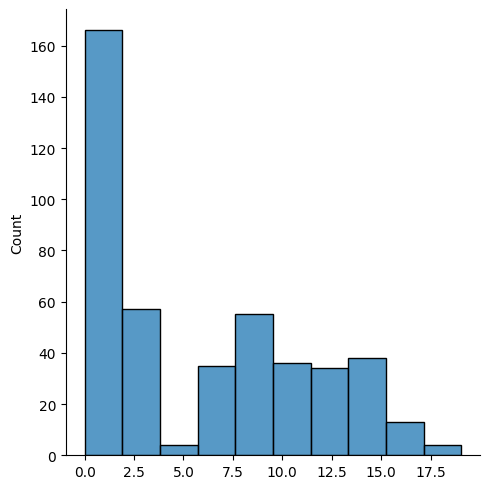

In [20]:
sns.displot(v)

Text(0.5, 9.444444444444438, 'Entropy of Q-values')

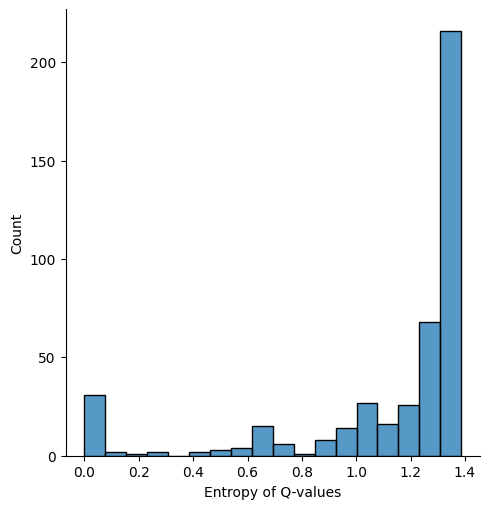

In [21]:
q_values = torch.stack([mdp.get_q_values(i) for i in range(len(v))])
pmf = torch.nn.functional.softmax(q_values, dim=1)
h = -torch.sum(pmf * torch.log(pmf), dim=1)
sns.displot(h)
plt.xlabel("Entropy of Q-values")

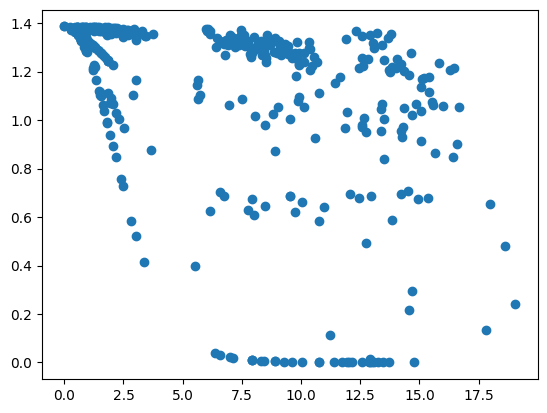

In [22]:
plt.scatter(v.numpy(), h.numpy())

In [23]:
mdp.rewards.reward_sums

tensor([[-3.2000, -3.3000, -4.4000, -3.1000],
        [-1.6000, -1.1000, -1.0000, -0.6000],
        [-3.3000, -2.5000, -3.5000, -2.5000],
        ...,
        [-0.1000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.1000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

In [24]:
mdp.rewards.reward_counts

tensor([[32., 33., 44., 31.],
        [16., 11., 10.,  6.],
        [33., 25., 35., 25.],
        ...,
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  1.,  1.,  1.]])

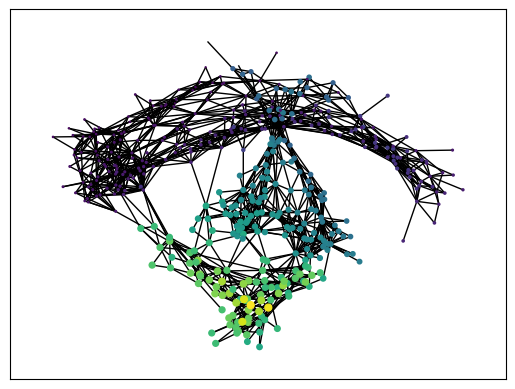

In [25]:


# convert the laplacian into a graph
edges = np.argwhere(Laplacian.numpy())
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)

# color = [node_values.get(i, 0) for i in G.nodes]
# size = [node_values.get(i, 0) for i in G.nodes]
color = [v[g] for g in G.nodes]
size = [v_normed[g] * 25 for g in G.nodes]
nx.draw_networkx(G, with_labels=False, node_size=size, node_color=color, cmap="viridis")



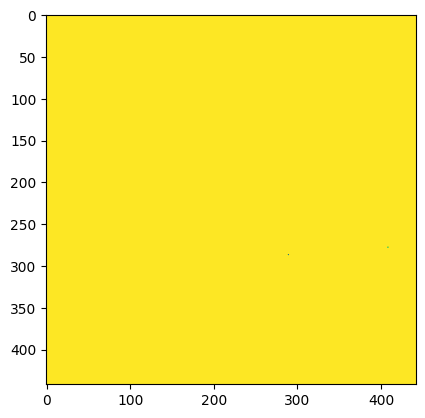

In [26]:
plt.imshow(Laplacian.numpy())

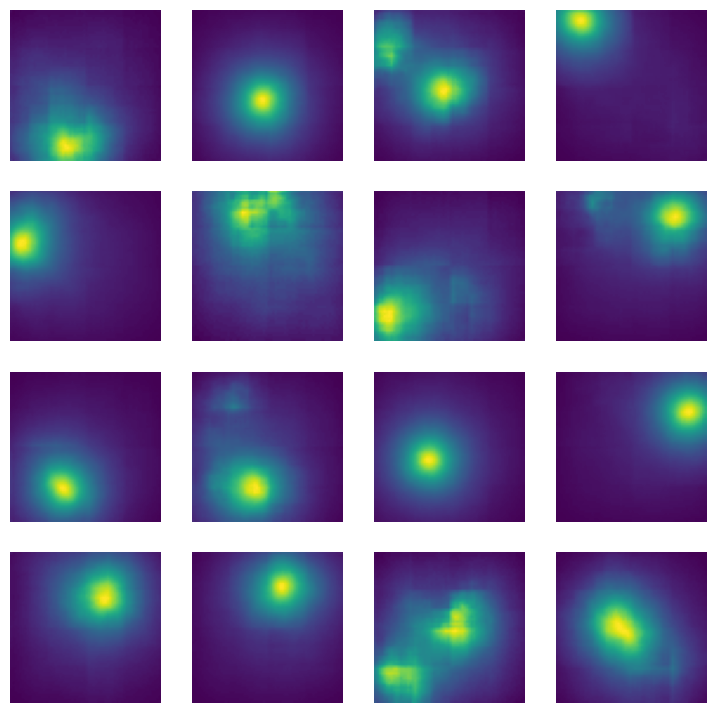

In [27]:
vae_model = agent.state_inference_model

import torch.nn.functional as F

# Sample generatively

z_layers = vae_config["vae_kwargs"]["z_layers"]
z_dim = vae_config["vae_kwargs"]["z_dim"]

N = 4


def sample_random_state():
    z = torch.randint(high=z_dim, size=tuple([z_layers]))
    return F.one_hot(z, num_classes=z_dim).to(DEVICE)


fig, axes = plt.subplots(N, N, figsize=(9, 9))

vae_model.eval()
for t in range(N**2):
    with torch.no_grad():
        z = sample_random_state()
    X_hat = vae_model.decode(z.to(DEVICE).float()).detach().cpu()

    r, c = t // N, t % N
    plt.sca(axes[r][c])
    plt.imshow(convert_float_to_8bit(X_hat.squeeze()))
    plt.axis("off")

plt.show()

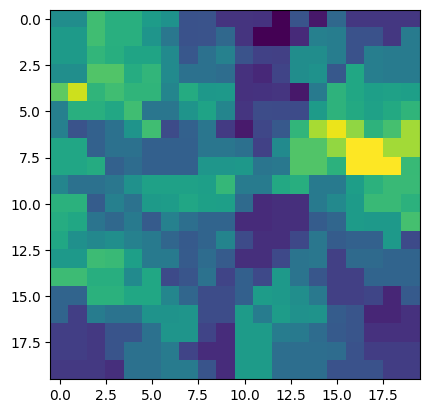

In [28]:
critic_values = []
for ii in range(400):
    obs = task.generate_observation(ii)
    critic_values.append(agent.get_critic_values(obs))


critic_values = torch.stack(critic_values).view(20, 20).detach().cpu().numpy()
plt.imshow(critic_values)

In [29]:

actor_values = []
for ii in range(400):
    obs = task.generate_observation(ii)
    actor_values.append(agent.get_actor_values(obs))
actor_values = torch.stack(actor_values)

In [30]:
actor_values

tensor([[-1.3871, -1.4214, -1.3891, -1.3489],
        [-1.3871, -1.4214, -1.3891, -1.3489],
        [-1.3871, -1.4214, -1.3891, -1.3489],
        ...,
        [-1.3871, -1.4214, -1.3891, -1.3489],
        [-1.3871, -1.4214, -1.3891, -1.3489],
        [-1.3871, -1.4214, -1.3891, -1.3489]], device='mps:0')

In [31]:
# sorted(list(agent.value_function.values()))

In [32]:
# import seaborn as sns

# fig, axes = plt.subplots(2, 2)
# h, w = env_kwargs["height"], env_kwargs["width"]

# axes[0][0].imshow(pmf[:, 0].reshape(h, w))
# axes[0][1].imshow(pmf[:, 1].reshape(h, w))
# axes[1][0].imshow(pmf[:, 2].reshape(h, w))
# axes[1][1].imshow(pmf[:, 3].reshape(h, w))


# axes[0][0].set_title("up")
# axes[0][1].set_title("down")
# axes[1][0].set_title("left")
# axes[1][1].set_title("right")

# plt.subplots_adjust(hspace=0.3, wspace=-0.3)

# plt.suptitle("Value Iteration Agent Learned Policy")

In [33]:
# np.sum(pi * pmf, axis=1).mean()

In [34]:
# room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
# room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
# room_3_mask = np.arange(400) % 20 >= 10

# score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
# score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
# score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
# plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

# sns.despine()

In [35]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

In [ ]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    )[:, None, ...].to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.imshow(v)
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
plt.plot(v[5] - np.nanmin(v))

In [ ]:
raise Exception("Stop here")

In [ ]:
from tqdm import trange


## Repeat with iterations
n_models = 8
# n_models=4


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=False)
    #     agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        vae_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

In [ ]:
# Plot the average value function (n)

# normalize the value function between zero and one within each iteration
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(grouped_data):
    v = grouped_data["State-Values"].values.reshape(-1, 1)
    v = MinMaxScaler().fit_transform(grouped_data["State-Values"].values.reshape(-1, 1))
    grouped_data["State-Values"] = v
    return grouped_data.drop("Iteration", axis=1)


normed_vf = value_functions.groupby("Iteration", group_keys=True).apply(min_max_scale)

# average and plot
plt.imshow(x.groupby("States").mean().values.reshape(20, 20))
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
# plot 1d Value function through the goal
normed_vf["Row"] = normed_vf["States"] // 20
normed_vf["Column"] = normed_vf["States"] % 20

sns.relplot(
    data=normed_vf[normed_vf["Row"] == 4], x="Column", y="State-Values", kind="line"
)
sns.relplot(
    data=normed_vf[(normed_vf["Column"] >= 9) & (normed_vf["Column"] <= 10)],
    x="Row",
    y="State-Values",
    kind="line",
    hue="Column",
)

plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv('value_functions_vae.csv')

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Model"] = "Value Iteration"
scores.to_csv(SAVE_FILE_NAME)
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"
scores3 = pd.read_csv("sims_thread_the_needle_state_inf.csv")
scores3["Model"] = "Value Iteration + action based decoder"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

In [ ]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])